In [2]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [3]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [4]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [1]:
# 如果没有安装pandas，请取消下一行的注释
# !pip install pandas

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l# 如果没有安装pandas，请取消下一行的注释



In [2]:
print(torch.cuda.is_available())

True


In [6]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [3]:
train_data = pd.read_csv(r'C:\DeepLearning\california-house-prices\train.csv')
test_data = pd.read_csv(r'C:\DeepLearning\california-house-prices\test.csv')

In [4]:
print(train_data.shape)
print(test_data.shape)

(47439, 41)
(31626, 40)


In [5]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id            Address  Sold Price  \
0   0        540 Pine Ln   3825000.0   
1   1     1727 W 67th St    505000.0   
2   2     28093 Pine Ave    140000.0   
3   3  10750 Braddock Dr   1775000.0   

                                             Summary         City    Zip State  
0  540 Pine Ln, Los Altos, CA 94022 is a single f...    Los Altos  94022    CA  
1  HURRY, HURRY.......Great house 3 bed and 2 bat...  Los Angeles  90047    CA  
2  'THE PERFECT CABIN TO FLIP!  Strawberry deligh...   Strawberry  95375    CA  
3  Rare 2-story Gated 5 bedroom Modern Mediterran...  Culver City  90230    CA  


all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [46]:

all_features = pd.concat((train_data.iloc[:, [i for i in range(train_data.shape[1]-1) if i not in [0,1,2,3,6,7,8,10,16,17,20,23,26,27,28,29,30,31,38,40]]], test_data.iloc[:, [i for i in range(test_data.shape[1]) if i not in [0,1,2,5,6,7,9,15,16,17,19,22,25,26,27,28,29,30,37,39]]]))

In [47]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [48]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(79065, 9958)

In [49]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data['Sold Price'].values.reshape(-1, 1), dtype=torch.float32)

定义尝试GPU计算的函数

In [51]:
def try_gpu(i=0):  #@save
    """如果存在，则返回gpu(i)，否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def try_all_gpus():  #@save
    """返回所有可用的GPU，如果没有GPU，则返回[cpu(),]"""
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

try_gpu(), try_gpu(10), try_all_gpus()

(device(type='cuda', index=0),
 device(type='cpu'),
 [device(type='cuda', index=0)])

In [72]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    # net = nn.Sequential(nn.Linear(in_features,1))
    net = nn.Sequential(nn.Flatten(),           # 将输入展平成一维向量
                    nn.Linear(in_features,256),  # 全连接层，输入特征数到512个神经元
                    nn.ReLU(),                   # ReLU激活函数
                    nn.Linear(256,128),
                    nn.ReLU(),
                    nn.Linear(128,64),
                    nn.ReLU(),
                    nn.Linear(64,1))            # 输出层，512维到1维

    return net

In [73]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [74]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    features, labels = features.to(device), labels.to(device)
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [75]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            # Move data to the GPU
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            X, y = X.to(device), y.to(device)
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [76]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [77]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        # Move the model to the GPU
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        net.to(device)
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse10.908924, 验证log rmse11.638261


KeyboardInterrupt: 

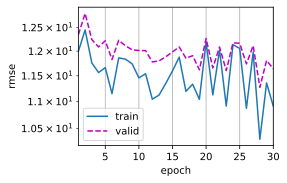

In [79]:
k, num_epochs, lr, weight_decay, batch_size = 5, 30, 50, 35, 128
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

Stage 1: Coarse tuning of learning rate and batch size
折1，训练log rmse0.247724, 验证log rmse0.525137
折2，训练log rmse0.293325, 验证log rmse0.490723
折3，训练log rmse0.218996, 验证log rmse0.408062
折4，训练log rmse0.204052, 验证log rmse0.410651
折5，训练log rmse0.239122, 验证log rmse0.417384
New best combination found: lr=0.1, bs=128, valid_error=0.4504
折1，训练log rmse0.227584, 验证log rmse0.468465
折2，训练log rmse0.220437, 验证log rmse0.412196
折3，训练log rmse0.182035, 验证log rmse0.383793
折4，训练log rmse0.171996, 验证log rmse0.401821
折5，训练log rmse0.339914, 验证log rmse0.620392
折1，训练log rmse0.266345, 验证log rmse0.575836
折2，训练log rmse0.712738, 验证log rmse1.004857
折3，训练log rmse0.297142, 验证log rmse0.534465
折4，训练log rmse0.270045, 验证log rmse0.532519
折5，训练log rmse0.212891, 验证log rmse0.505527
折1，训练log rmse0.868629, 验证log rmse0.789283
折2，训练log rmse0.854409, 验证log rmse0.814990
折3，训练log rmse0.862459, 验证log rmse0.844650
折4，训练log rmse0.869896, 验证log rmse0.881887
折5，训练log rmse4.955169, 验证log rmse4.743833
折1，训练log rmse0.555749, 验证log rmse0.689671


KeyboardInterrupt: 

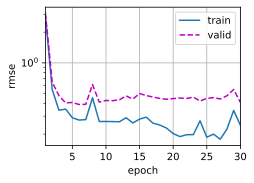

In [80]:
import numpy as np
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

def find_best_hyperparameters(train_features, train_labels, k=5):
    """
    使用分阶段策略寻找最佳超参数
    """
    def evaluate_params(lr, wd, bs, epochs):
        """评估特定参数组合"""
        try:
            train_l, valid_l = k_fold(
                k=k,
                X_train=train_features,
                y_train=train_labels,
                num_epochs=epochs,
                learning_rate=lr,
                weight_decay=wd,
                batch_size=bs
            )
            return float(valid_l)  # 返回验证集误差
        except Exception as e:
            print(f"Error with parameters: lr={lr}, wd={wd}, bs={bs}, epochs={epochs}")
            print(f"Error message: {str(e)}")
            return float('inf')

    # 第一阶段：粗调学习率和批量大小
    print("Stage 1: Coarse tuning of learning rate and batch size")
    learning_rates = [0.1, 1, 10, 100]
    # learning_rates = [0.05]
    batch_sizes = [128, 256, 512]
    best_lr = 0.1
    best_bs = 64
    best_valid_error = float('inf')

    for lr in learning_rates:
        for bs in batch_sizes:
            valid_error = evaluate_params(
                lr=lr,
                wd=0,  # 初始不使用权重衰减
                bs=bs,
                epochs=25  # 使用较少的epoch快速评估
            )
            if valid_error < best_valid_error:
                best_valid_error = valid_error
                best_lr = lr
                best_bs = bs
                print(f"New best combination found: lr={best_lr}, bs={best_bs}, valid_error={best_valid_error:.4f}")

    # 第二阶段：在最佳学习率附近细调
    print("\nStage 2: Fine tuning of learning rate")
    fine_lr_range = np.linspace(best_lr/2, best_lr*2, 5)
    for lr in fine_lr_range:
        valid_error = evaluate_params(
            lr=lr,
            wd=0,
            bs=best_bs,
            epochs=30
        )
        if valid_error < best_valid_error:
            best_valid_error = valid_error
            best_lr = lr
            print(f"New best learning rate found: lr={best_lr}, valid_error={best_valid_error:.4f}")

    # 第三阶段：调整权重衰减
    print("\nStage 3: Tuning weight decay")
    weight_decays = [10, 100, 1000, 10000]
    best_wd = 0
    for wd in weight_decays:
        valid_error = evaluate_params(
            lr=best_lr,
            wd=wd,
            bs=best_bs,
            epochs=30
        )
        if valid_error < best_valid_error:
            best_valid_error = valid_error
            best_wd = wd
            print(f"New best weight decay found: wd={best_wd}, valid_error={best_valid_error:.4f}")

    # 第四阶段：确定最佳epoch数
    print("\nStage 4: Determining optimal number of epochs")
    epochs_range = [30, 50, 100]
    best_epochs = 30
    for epochs in epochs_range:
        valid_error = evaluate_params(
            lr=best_lr,
            wd=best_wd,
            bs=best_bs,
            epochs=epochs
        )
        if valid_error < best_valid_error:
            best_valid_error = valid_error
            best_epochs = epochs
            print(f"New best number of epochs found: epochs={best_epochs}, valid_error={best_valid_error:.4f}")

    # 最终验证
    print("\nFinal validation with best parameters")
    final_valid_error = evaluate_params(
        lr=best_lr,
        wd=best_wd,
        bs=best_bs,
        epochs=best_epochs
    )

    best_params = {
        'learning_rate': best_lr,
        'weight_decay': best_wd,
        'batch_size': best_bs,
        'num_epochs': best_epochs,
        'final_valid_error': final_valid_error
    }

    print("\nBest Parameters Found:")
    print(f"Learning Rate: {best_params['learning_rate']}")
    print(f"Weight Decay: {best_params['weight_decay']}")
    print(f"Batch Size: {best_params['batch_size']}")
    print(f"Number of Epochs: {best_params['num_epochs']}")
    print(f"Final Validation Error: {best_params['final_valid_error']:.4f}")

    return best_params

# 使用示例
if __name__ == "__main__":
    # 确保数据已经准备好
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # 将数据移动到正确的设备
    train_features = train_features.to(device)
    train_labels = train_labels.to(device)
    
    # 运行超参数搜索
    best_params = find_best_hyperparameters(train_features, train_labels)

In [132]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.068003


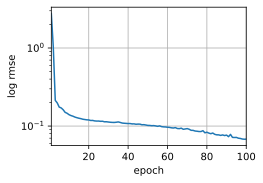

In [133]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

In [1]:
import torch
print(f"CUDA is available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

CUDA is available: False
CUDA version: None


In [1]:
import torch
print(torch.__version__)  # 检查 PyTorch 版本
print(torch.version.cuda)  # 检查 CUDA 版本
print(torch.cuda.is_available())  # 检查 CUDA 是否可用

2.7.0.dev20250126+cu126
12.6
True
